In [1]:
#----------------------------------------------------------------------
# create_noisy_dataset.py
#
# Create a noisy signal with given properties
#
# Created: September 6, 2018 - Daniel M Newman -- danielnewman@gatech.edu
#
# Modified:
#   * Septermber 6, 2018 - DMN
#            - Added documentation for this script
#----------------------------------------------------------------------

import numpy as np
import warnings
import json
import sys
# from ML_Train.DBQuerier import DBQuerier as Querier

# import libraries
import os
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)

import glob
from datetime import datetime


# import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

from scipy.signal import welch
from crawlab_toolbox.freq_tools import welch_stat
from scipy.stats import describe
from utils import lin_log_interp

# from DBInserter import DBInserter

from crawlab_toolbox import plotting as genplt
# plt.rcParams['figure.figsize'] = (15, 4)


In [2]:
def create_noisy_signal(
    duration, samplingRate, frequencies, amplitudes,
    noiseStDev, phase, 
    frequencyError=0.05, harmonics=1,
    saveSignal=False,fileName='signal'):
    '''
    create_noisy_signal

    Create a signal with desired randomness and spectral qualities.

    Inputs:
        - duration: time (in seconds) captured by the signal
        - samplingRate: rate (in Hz) of the signal
        - frequencies: list of frequencies in the signal
        - amplitudes: amplitudes of the corresponding frequencies
        - (float) noiseStDev: standard deviation squared) of
                the gaussian noise added to the signal
        - (float) frequencyStDev: standard deviation
                of the gaussian noise added to the frequency
        - (float) amplitudeStDev: standard deviation
                of the gaussian noise added to the amplitudes
        - (float) phaseStDev: StDev (standard deviation squared) of
                the gaussian noise added to the phase of the signal

    '''

    # determine the required number of datapoints to cover the duration
    # at the required sampling rate
    numPoints = int(duration * samplingRate)

    # Create a time array with the correct start and endpoint, sampled at
    # the required sampling rates
    time = np.atleast_2d(np.linspace(0,duration,numPoints))

    # Ensure that all of the inputs are cast as numpy arrays
    freqs = np.atleast_2d(np.asarray(frequencies).flatten()).T
    amps = np.atleast_2d(np.asarray(amplitudes).flatten()).T
    noiseStDev = np.asarray(noiseStDev)

    # Modify the signal slightly
    m, n = freqs.shape
#     phase = np.atleast_2d(phaseStDev * np.random.random((m, n)))

    # Create randomly distributed noise with a given standard deviation
    noise = noiseStDev * np.random.random(numPoints)

    # The number of input frequencies must be identical to the number
    # of input amplitudes
    if len(freqs) != len(amps):
        raise ValueError('Length of input frequencies must be identical to\
                          that of input amplitudes')

    signal = np.sum(amps * np.sin(2 * np.pi * freqs * time + phase), axis=0) + noise

    if saveSignal:
        fName = fileName + '.txt'
        timeName = fileName + '_time.txt'
        np.savetxt(fName, np.round(signal,6), header='Signal', delimiter=',')
        np.savetxt(timeName, np.round(time,6), header='Time (s)', delimiter=',')

    return time.flatten(), signal

In [3]:
def parse_data(data,samplingRate,fftPoints,assetId,sensorId,vibrationState):
    
    currDate = datetime.now()
    datetime_string = currDate.strftime('%Y-%m-%d %H:%M:%S.%f')
    
    freqs,amps = welch(data.T,fs=samplingRate,nperseg=fftPoints)
    amps = amps.flatten()[1:]
    
    this_rms = np.sqrt(1 / np.array(data).shape[0] * np.sum(np.array(data)**2,axis=0))
    
    _,minmax,mean,variance,skewness,kurtosis = describe(data)

    NyquistFrequency = 0.5 * samplingRate

    frequencyInterval = freqs[1] - freqs[0]

    sampleRMS = np.sqrt(1 / data.shape[0] * np.sum(data**2,axis=0))
    
    stats = np.array([sampleRMS,mean,kurtosis,skewness,variance]).reshape(1,5)
    amps = lin_log_interp(amps).reshape(1,amps.shape[0])
    
    return stats,amps
    

In [4]:
samplingRate = 8192
duration = 1
fftPoints = 2048

columns = ['RMS','Mean','Kurtosis','Skewness','Variance']


NyquistFreq = 0.5 * samplingRate

train_amplitudes = np.linspace(0.1,2.5,10)
train_frequencies = np.linspace(0.1 * NyquistFreq, 0.3 * NyquistFreq,10)
valid_amplitudes = np.linspace(0.1,2.5,20)[1::2]
valid_frequencies = np.linspace(0.1 * NyquistFreq, 0.3 * NyquistFreq,20)[1::2]

noiseStdDev = np.linspace(0.1,0.1,1)
sampleRepetitions = 7

assetId = 'Example-NoNoise-VaryAmplitude-VaryPhase'
database = 'db18'



In [5]:
valid_amplitudes
valid_frequencies

array([ 452.71578947,  538.94736842,  625.17894737,  711.41052632,
        797.64210526,  883.87368421,  970.10526316, 1056.33684211,
       1142.56842105, 1228.8       ])

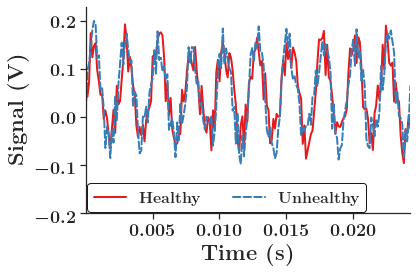

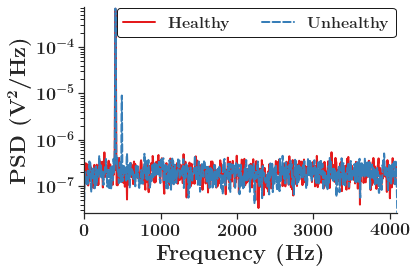

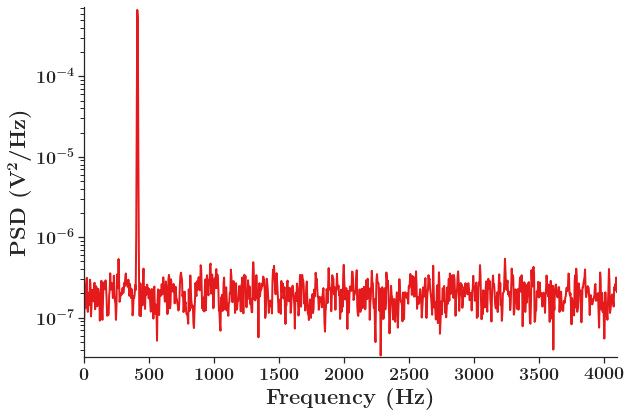

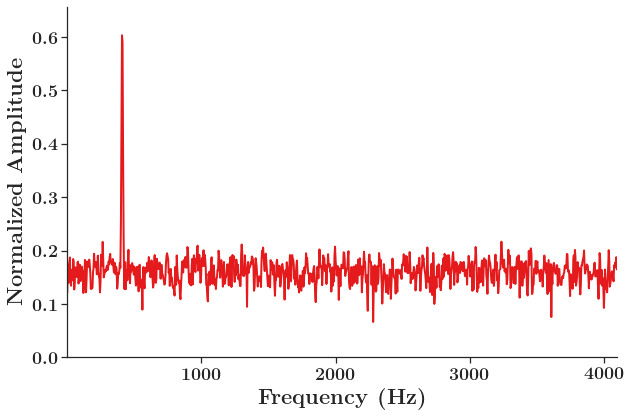

In [10]:
thisTime,unhealthySignal = create_noisy_signal(1,samplingRate,[train_frequencies[0],train_frequencies[0]*1.2],[train_amplitudes[0],0.1*train_amplitudes[0]],noiseStdDev[0],0,)
thisTime,healthySignal = create_noisy_signal(1,samplingRate,[train_frequencies[0]],[train_amplitudes[0]],noiseStdDev[0],0,)

# plt.plot(thisSignal)
# plt.show()


# combine the responses and labels to put on our 2D plot
responses = np.vstack((healthySignal,unhealthySignal))
labels = [r'Healthy','Unhealthy']

numPoints = 200

# Create a 2D plot
genplt.generate_plot(thisTime[:200], # X - coordinate on the plot
              responses[:,:200],# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Time (s)',# X - axis label
              'Signal (V)',   # Y - axis label
              filename='Test_Signal',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     log_y=False,
                     ymin=0.05,
              transparent=False,
              showplot=True,
              save_plot=True,
              template='publication',
              file_type='png'
             )

freqs,healthyAmps = welch(healthySignal.T,fs=samplingRate,nperseg=fftPoints)
freqs,unhealthyAmps = welch(unhealthySignal.T,fs=samplingRate,nperseg=fftPoints)




# combine the responses and labels to put on our 2D plot
responses = np.vstack((healthyAmps,unhealthyAmps))
labels = [r'Healthy','Unhealthy']

# Create a 2D plot
genplt.generate_plot(freqs, # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (Hz)',# X - axis label
              r'PSD $(\mathrm{V}^2/\mathrm{Hz})$',   # Y - axis label
              filename='Test_Signal_FFT',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
              log_y=True,
              ymin=0.05,
              transparent=False,
              showplot=True,
              save_plot=True,
              template='publication',
              file_type='png'
             )

# combine the responses and labels to put on our 2D plot
responses = np.vstack((healthyAmps))
labels = [r'']

# Create a 2D plot
genplt.generate_plot(freqs, # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (Hz)',# X - axis label
              r'PSD $(\mathrm{V}^2/\mathrm{Hz})$',   # Y - axis label
              filename='FFT_Log_Example',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
              log_y=True,
              ymin=0.05,
              transparent=True,
              showplot=True,
              save_plot=True,
              template='presentation',
              file_type='svg'
             )

# combine the responses and labels to put on our 2D plot
responses = np.vstack((lin_log_interp(healthyAmps)))
labels = [r'']

# Create a 2D plot
genplt.generate_plot(freqs, # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (Hz)',# X - axis label
              r'Normalized Amplitude',   # Y - axis label
              filename='FFT_Norm_Example',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
              log_y=False,
              ymin=0.05,
              transparent=True,
              showplot=True,
              save_plot=True,
              template='presentation',
              file_type='svg'
             )



In [8]:
thisState = 'valid'

In [49]:
fftAmps = np.zeros((0,int(fftPoints//2)))
stats = np.zeros((0,5))
vibState = np.zeros((0,1))

if thisState == 'train':
    amplitudes = train_amplitudes
    frequencies = train_frequencies
if thisState == 'valid':
    amplitudes = valid_amplitudes
    frequencies = valid_frequencies

# Create Training Data
for i in range(len(amplitudes)):
    thisAmp = amplitudes[i]
    for j in range(len(frequencies)):
        thisFreq = frequencies[j]
        for k in range(len(noiseStdDev)):
            thisNoise = noiseStdDev[k]
            
            sensorId = 'SNR-{}'.format(np.round(thisAmp / thisNoise,3))
            vibrationState = 'Healthy'
            
            for l in range(sampleRepetitions):

                _,signal = create_noisy_signal(duration,samplingRate,thisFreq,thisAmp,thisNoise,0,)

                thisStats,thisfftAmps = parse_data(signal,samplingRate,fftPoints,assetId,sensorId,vibrationState)
                
                stats = np.vstack((thisStats,stats))
                fftAmps = np.vstack((thisfftAmps,fftAmps))
                vibState = np.vstack((vibState,np.array(['Healthy']).reshape(1,1)))

# Create Training Data
for i in range(len(amplitudes)):
    thisAmp = amplitudes[i]
    for j in range(len(frequencies)):
        thisFreq = frequencies[j]
        for k in range(len(noiseStdDev)):
            thisNoise = noiseStdDev[k]
            
            sensorId = 'SNR-{}'.format(np.round(thisAmp / thisNoise,3))
            vibrationState = 'Unhealthy'
            
            for l in range(sampleRepetitions):

                _,signal = create_noisy_signal(duration,
                                               samplingRate,
                                               [thisFreq,thisFreq*1.4],
                                               [thisAmp,thisAmp*0.1],
                                               thisNoise,0,)

                thisStats,thisfftAmps = parse_data(signal,samplingRate,fftPoints,assetId,sensorId,vibrationState)
                
                stats = np.vstack((thisStats,stats))
                fftAmps = np.vstack((thisfftAmps,fftAmps))
                vibState = np.vstack((vibState,np.array(['Unhealthy']).reshape(1,1)))

fftFeaturesDF = pd.DataFrame(fftAmps)
vibStateDF = pd.DataFrame(vibState)
statsDF = pd.DataFrame(stats,columns=columns)

fftFeaturesDF.to_csv('data/featuresDF_{}.csv'.format(thisState))
vibStateDF.to_csv('data/vibState_{}.csv'.format(thisState))
statsDF.to_csv('data/stats_{}.csv'.format(thisState))

In [46]:
statsDF.head()

,RMS,Mean,Kurtosis,Skewness,Variance
0,1.777648,0.050051,-1.470319,0.000193,3.157914
1,1.777313,0.049751,-1.469075,-0.000230,3.156753
2,1.777512,0.049681,-1.470926,-0.000261,3.157466
3,1.777596,0.050132,-1.470341,-0.000416,3.157718
4,1.777338,0.050132,-1.470140,-0.000846,3.156804


In [47]:
fftFeaturesDF.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.188211,0.160125,0.156641,0.169999,0.175439,0.167284,0.150734,0.143829,0.145850,0.161568,...,0.163029,0.176305,0.147632,0.175673,0.159720,0.170500,0.138353,0.122810,0.165602,0.102121
1,0.171272,0.158997,0.163922,0.157754,0.183803,0.199646,0.182792,0.175374,0.179539,0.157577,...,0.178588,0.160231,0.163998,0.171885,0.156585,0.178085,0.192316,0.194109,0.169708,0.016249
2,0.172887,0.145511,0.181892,0.186335,0.136027,0.166255,0.184540,0.206859,0.199725,0.193871,...,0.144814,0.174870,0.144031,0.175293,0.164045,0.160081,0.137482,0.172845,0.152232,0.065044
3,0.202423,0.200880,0.177266,0.128070,0.176965,0.181493,0.164466,0.141923,0.143791,0.149097,...,0.161671,0.147970,0.153780,0.157166,0.131236,0.203090,0.198438,0.170092,0.141526,0.108089
4,0.204163,0.162077,0.136268,0.144317,0.142838,0.156801,0.174427,0.164481,0.159360,0.177294,...,0.165742,0.138290,0.128603,0.153667,0.157105,0.170657,0.163473,0.170567,0.161913,0.099756
